In [1]:
import pandas as pd

from molloader import *
from ML_utils import *

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, KFold, ParameterGrid

In [2]:
def drop_duplicates(df):
    df = df.drop_duplicates(subset="compound", keep="first")
    print("Number of molecules", df.shape[0])
    return df

In [3]:
def get_all_elements(df):
      return np.unique(np.hstack(np.array(df.species)))

In [4]:
class VoxelNet(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        # (N, C, D, H, W)
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, 3, padding=0, stride=1),
            #nn.BatchNorm3d(16),
            nn.SELU(),
            nn.MaxPool3d(2))
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.SELU(),
            nn.MaxPool3d(2))
        
        self.conv3 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.SELU())
        
        self.regressor = nn.Sequential(nn.Flatten(),
                                        nn.Linear(1024, 32),
                                        nn.SELU(),
                                        nn.Linear(32, 8),
                                        nn.SELU(),
                                        nn.Linear(8, 1))
    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        # print("conv1", x.shape)
        x = self.conv2(x)
        # print("conv2", x.shape)
        x = self.conv3(x)
        # print("conv3", x.shape)
        x = self.regressor(x)
        return x

In [5]:
df = pd.read_pickle("data/all_221_cp5_3_species_oxides.pkl")
df = drop_duplicates(df)
df

Number of molecules 1983


,auid,aurl,compound,composition,species,natoms,spacegroup,pearson_symbol,geometry,positions_fractional,positions_cartesian,enthalpy_atom,enthalpy_formation_atom
0,aflow:b778fabdb1b01db1,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgAlO/T00...,Ag1Al1O3,"[1, 1, 3]","[Ag, Al, O]",5,221,cP5,"[3.7688035, 3.7688035, 3.7688035, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [1.8844, 1.8844, 1.8844], [0...",-5.04863,-0.775736
2,aflow:272cd0e74db84a51,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgAsO/T00...,Ag1As1O3,"[1, 1, 3]","[Ag, As, O]",5,221,cP5,"[3.7951634, 3.7951634, 3.7951634, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [1.89758, 1.89758, 1.89758],...",-4.55519,-0.100528
4,aflow:7e6bdbc495310b44,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgAuO/T00...,Ag1Au1O3,"[1, 1, 3]","[Ag, Au, O]",5,221,cP5,"[4.1003175, 4.1003175, 4.1003175, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [2.05016, 2.05016, 2.05016],...",-2.80408,1.37453
6,aflow:c0e1c25976bb4c75,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgB_hO/T0...,Ag1B1O3,"[1, 1, 3]","[Ag, B, O]",5,221,cP5,"[3.484261, 3.484261, 3.484261, 90.0, 90.0, 90.0]","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [1.74213, 1.74213, 1.74213],...",-4.55549,0.30734
8,aflow:3b79b8b28a5d5cc1,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgBa_svO/...,Ag1Ba1O3,"[1, 1, 3]","[Ag, Ba, O]",5,221,cP5,"[4.7271734, 4.7271734, 4.7271734, 90.0, 90.0, ...","[[-0.0, 0.0, -0.0], [0.5, 0.5, 0.5], [-0.0, 0....","[[-0.0, 0.0, -0.0], [2.36359, 2.36359, 2.36359...",-3.52096,0.388015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,aflow:e243d024b0749ac0,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OXeZn/T00...,O3Xe1Zn1,"[3, 1, 1]","[O, Xe, Zn]",5,221,cP5,"[4.370543, 4.370543, 4.370543, 90.0, 90.0, 90.0]","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[0.0, 2.18527, 2.18527], [2.18527, 0.0, 2.185...",-1.89960,None
3949,aflow:ae4a07b2d68c2933,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OXeZr_sv/...,O3Xe1Zr1,"[3, 1, 1]","[O, Xe, Zr]",5,221,cP5,"[4.322477, 4.322477, 4.322477, 90.0, 90.0, 90.0]","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[-0.0, 2.16124, 2.16124], [2.16124, -0.0, 2.1...",-5.89112,-1.222
3951,aflow:0d9d3ce033a32aae,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OY_svZn/T...,O3Y1Zn1,"[3, 1, 1]","[O, Y, Zn]",5,221,cP5,"[4.3517566, 4.3517566, 4.3517566, 90.0, 90.0, ...","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[0.0, 2.17588, 2.17588], [2.17588, 0.0, 2.175...",-5.57716,-1.07268
3953,aflow:627232532ed2fb40,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OY_svZr_s...,O3Y1Zr1,"[3, 1, 1]","[O, Y, Zr]",5,221,cP5,"[4.155165, 4.155165, 4.155165, 90.0, 90.0, 90.0]","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[0.0, 2.07758, 2.07758], [2.07758, 0.0, 2.077...",-8.70129,-2.74124


In [6]:
elements = get_all_elements(df)
nchannel = len(elements)
nchannel, elements

(79,
 array(['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca',
        'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'F',
        'Fe', 'Ga', 'Gd', 'Ge', 'Hf', 'Hg', 'Ho', 'I', 'In', 'Ir', 'K',
        'La', 'Li', 'Lu', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd', 'Ni',
        'O', 'Os', 'P', 'Pa', 'Pb', 'Pd', 'Pr', 'Pt', 'Pu', 'Rb', 'Re',
        'Rh', 'Ru', 'S', 'Sb', 'Sc', 'Se', 'Si', 'Sn', 'Sr', 'Ta', 'Tb',
        'Tc', 'Te', 'Th', 'Ti', 'Tl', 'U', 'V', 'W', 'Xe', 'Y', 'Yb', 'Zn',
        'Zr'], dtype='<U2'))

In [7]:
net = VoxelNet(nchannel)
count_parameters(net)

81073

##  Cartesian

In [8]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()


seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

seed_everything()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=32, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=True, mode='cartesian')

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, reduce_data=True, mode='cartesian')

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0.01)

(1784, 13) (199, 13)
Initialised MolLoader with 1784 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 5.73125696182251 val loss 2.317413091659546
Epoch 1: train loss 2.0544168949127197 val loss 2.1811585426330566
Epoch 2: train loss 1.7972078323364258 val loss 1.7585550546646118


KeyboardInterrupt: 

### Train Plots

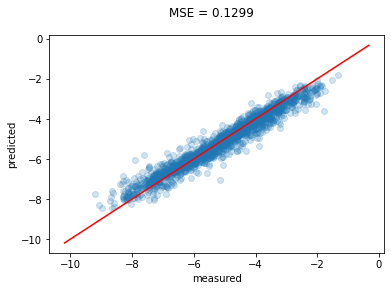

In [23]:
# 0.1299
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)

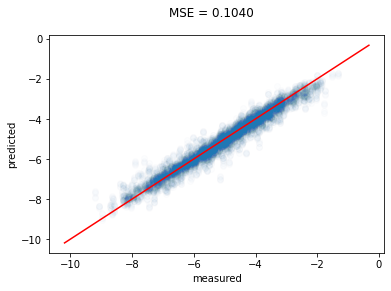

In [24]:
# 0.1040
# rotations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats, alpha=0.01)

### Test Plots

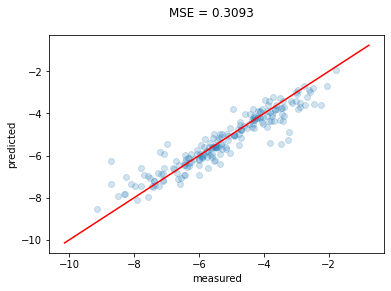

In [25]:
# 0.3093
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)

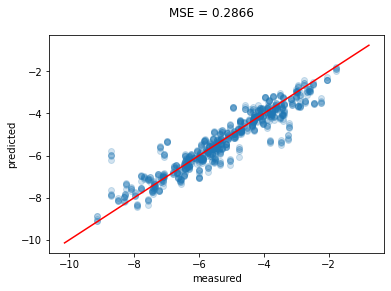

In [26]:
# 0.2866
# rotations
seed_everything()
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats)

## Spherical

(1784, 13) (199, 13)
Initialised MolLoader with 1784 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 9.046587944030762 val loss 3.4036097526550293
Epoch 1: train loss 2.169504404067993 val loss 2.183715343475342
Epoch 2: train loss 1.8985360860824585 val loss 1.8495608568191528
Epoch 3: train loss 1.2516200542449951 val loss 0.7765289545059204
Epoch 4: train loss 0.45786356925964355 val loss 0.49583837389945984
Epoch 5: train loss 0.3763634264469147 val loss 0.5120257139205933
Epoch 6: train loss 0.36201122403144836 val loss 0.4489908218383789
Epoch 7: train loss 0.37416720390319824 val loss 0.4667428135871887
Epoch 8: train loss 0.38513967394828796 val loss 0.5348819494247437
Epoch 9: train loss 0.33678337931632996 val loss 0.4286249577999115
Epoch 10: train loss 0.32

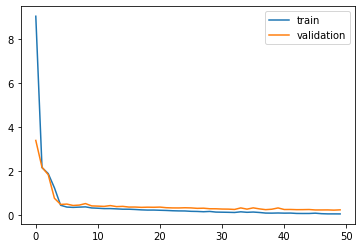

In [13]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()


seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

seed_everything()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=True, mode='spherical')

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, reduce_data=True, mode='spherical')

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0.00)

### Train Plots

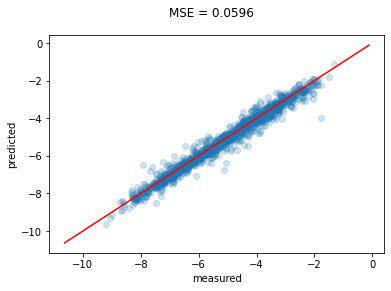

In [14]:
# 0.0723
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)

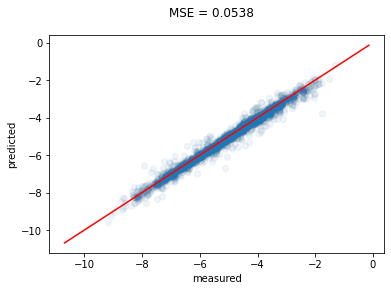

In [15]:
# 0.0669
# rotations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats, alpha=0.01)

Initialised MolLoader with 1784 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=False, rotate=True, device=cuda


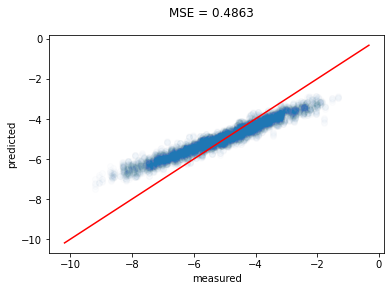

In [16]:
seed_everything()
ml_wrong_mode_pred = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=True, device=device, reduce_data=True, mode='cartesian')
ys, y_hats = predict_epochs(net, ml_wrong_mode_pred, epochs=5)
plot_predictions(ys, y_hats, alpha=0.01)

### Test Plots

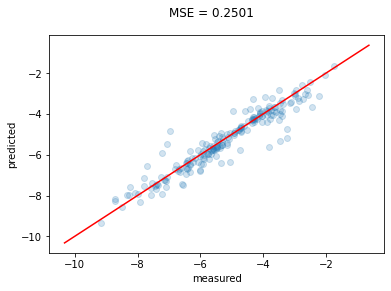

In [17]:
# 0.2716
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)

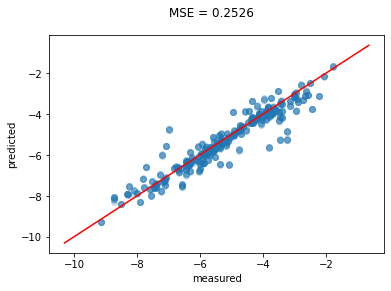

In [18]:
# 0.2629
# rotations
seed_everything()
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats)

## Cross Validation

### Cartesian

In [ ]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()

seed_everything()
all_ys = []
all_y_hats = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(df):
    
    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]

    net = VoxelNet(nchannel)
    net = net.to(device)
    
    ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device)

    ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device)
    
    fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)
    
    ml_pred = ml_test
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    
    all_ys.append(ys)
    all_y_hats.append(y_hats)

In [ ]:
# 0.2881
plot_predictions(np.hstack(all_ys), np.hstack(all_y_hats), alpha=0.01)

### Spherical

In [ ]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()

seed_everything()
all_ys = []
all_y_hats = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(df):
    
    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]

    net = VoxelNet(nchannel)
    net = net.to(device)
    
    ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, mode='spherical')

    ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, mode='spherical')
    
    fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)
    
    ml_pred = ml_test
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    
    all_ys.append(ys)
    all_y_hats.append(y_hats)

In [ ]:
# 0.2658
plot_predictions(np.hstack(all_ys), np.hstack(all_y_hats), alpha=0.01)

In [ ]:
# (in_channels, 64)
# (64, 128)
# (128, 128)  (128,128)

# (128, 256)
# (256, 512)
# (512, 512) (512, 512)

# (512, 64)
# (64, 1)

In [9]:
def conv_block(in_channels, out_channels, kernel_size=3, pool=False):
    layers = [nn.Conv3d(in_channels, out_channels, kernel_size, padding=1), 
              nn.BatchNorm3d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool3d(2))
    return nn.Sequential(*layers)

class ResNet93D(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.regressor = nn.Sequential(nn.MaxPool3d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(256, 64),
                                        nn.ReLU(),
                                        nn.Linear(64,1))
        
    def forward(self, xb):
        #print("in", xb.shape)
        out = self.conv1(xb)
        #print("conv1", out.shape)
        out = self.conv2(out)
        #print("conv2", out.shape)
        out = self.res1(out) + out
        #print("res1", out.shape)
        out = self.conv3(out)
        #print("conv3", out.shape)
        out = self.conv4(out)
        #print("conv4", out.shape)
        out = self.res2(out) + out
        #print("conv2", out.shape)
        out = self.regressor(out)
        return out

In [11]:
sigma = 0.1
L = 12.8
N = 32

x = None
y = None
ml = MolLoader(df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, reduce_data=True, mode='cartesian')
for names, bx, by in ml:
    x = bx
    y = by
    break

Initialised MolLoader with 1983 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=False, rotate=False, device=cpu


In [25]:
torch.cuda.empty_cache()

In [10]:
device = get_default_device()

In [11]:
net = ResNet93D(nchannel)
count_parameters(net)

3380993

In [12]:
net_gpu = net.to(device)

In [16]:
x_gpu = x.to(device)

RuntimeError: CUDA out of memory. Tried to allocate 632.00 MiB (GPU 0; 8.00 GiB total capacity; 5.97 GiB already allocated; 266.89 MiB free; 6.27 GiB reserved in total by PyTorch)

In [12]:
x.data.numel() * 4 / 1024**2

1264.0

In [15]:
out = net_gpu(x_gpu)

In [26]:
def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                        " GPU" if obj.is_cuda else "",
                                        " pinned" if obj.is_pinned else "",
                                        pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                    type(obj.data).__name__, 
                                                    " GPU" if obj.is_cuda else "",
                                                    " pinned" if obj.data.is_pinned else "",
                                                    " grad" if obj.requires_grad else "", 
                                                    " volatile" if obj.volatile else "",
                                                    pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)

In [27]:
dump_tensors()

Parameter: GPU pinned 128 × 79 × 3 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 128 × 3 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 256 × 128 × 3 × 3 × 3
Parameter: GPU pinned 256
Parameter: GPU pinned 256
Parameter: GPU pinned 256
Parameter: GPU pinned 256 × 256 × 3 × 3 × 3
Parameter: GPU pinned 256
Parameter: GPU pinned 256
Parameter: GPU pinned 256
Parameter: GPU pinned 256 × 256 × 3 × 3 × 3
Parameter: GPU pinned 256
Parameter: GPU pinned 256
Parameter: GPU pinned 256
Parameter: GPU pinned 256 × 256 × 3 × 3 × 3
Parameter: GPU pinned 256
Parameter: GPU pinned 256
Parameter: GPU pinned 256
Parameter: GPU pinned 128 × 128 × 3 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 128 × 3 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Tensor: GPU pinned 128
Te

c:\users\marku\appdata\local\programs\python\python38\lib\site-packages\torch\distributed\distributed_c10d.py:126: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


In [29]:
173492553 * 4 / 1024**2

661.8215675354004

(1784, 13) (199, 13)
Initialised MolLoader with 1784 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 1.8262977600097656 val loss 8.04896354675293
Epoch 1: train loss 0.4510297477245331 val loss 1.9659408330917358
Epoch 2: train loss 0.3771815896034241 val loss 0.6979295015335083
Epoch 3: train loss 0.3943122625350952 val loss 0.890421986579895
Epoch 4: train loss 0.4102896749973297 val loss 0.5664874315261841
Epoch 5: train loss 0.3322109282016754 val loss 2.550558567047119
Epoch 6: train loss 0.293984591960907 val loss 1.0398426055908203
Epoch 7: train loss 0.39401957392692566 val loss 0.49667495489120483
Epoch 8: train loss 0.3220355808734894 val loss 2.4982874393463135
Epoch 9: train loss 0.3059549927711487 val loss 3.1999199390411377
Epoch 10: train loss 0.31826549

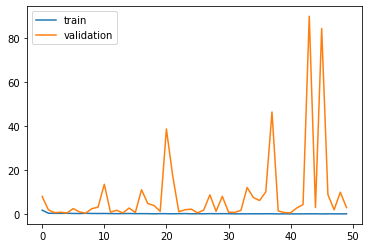

In [10]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()
device = torch.device('cpu')

seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

seed_everything()

net = ResNet93D(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=32, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=True, mode='cartesian')

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=32, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, reduce_data=True, mode='cartesian')

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0.01)

In [10]:
torch.cuda.empty_cache()

In [9]:
del net